### Exploration of the use of Cartopy and Geopandas to plot global earthquake maps 

Here we'll make some nice maps of global seismcity and demonstrate some of the features
of geopandas for dealing with geospatial polygons

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
from datetime import datetime
import cartopy.feature as cfeature
from matplotlib.transforms import offset_copy
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
import geopandas as gpd

In [3]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

Get all global events

In [4]:
client = Client("IRIS")
starttime = '1980-01-01'
endtime = str(datetime.now()).split()[0]
minmag = 6
quake_catalog = client.get_events(starttime=UTCDateTime(starttime),endtime=UTCDateTime(endtime),\
                            minmagnitude=minmag)

Generate a dataframe, which makes plotting the events easier

In [5]:
LLD = np.zeros([len(quake_catalog),4])

for i in range(len(quake_catalog)):
    event = quake_catalog[i]
    LLD[i,0] = event.origins[0].longitude
    LLD[i,1] = event.origins[0].latitude
    
    depth = event.origins[0].depth
    if depth == None:
        LLD[i,2] = np.nan
    else:
        LLD[i,2] = depth/1000
        
    LLD[i,3] = event.magnitudes[0].mag

eventdetails = pd.DataFrame(LLD)
eventdetails.columns = ['LON','LAT','DEP','MAG']
eventdetails.dropna(inplace=True )

Make a nice global map of events, colored by depth and scaled by magnitude

See https://scitools.org.uk/cartopy/docs/latest/crs/projections.html for the possible projections

In [6]:
def scale_events(events):
    
    '''Function to scale earthquakes so that they look good in a map'''
    
    return 0.1*np.exp(events)

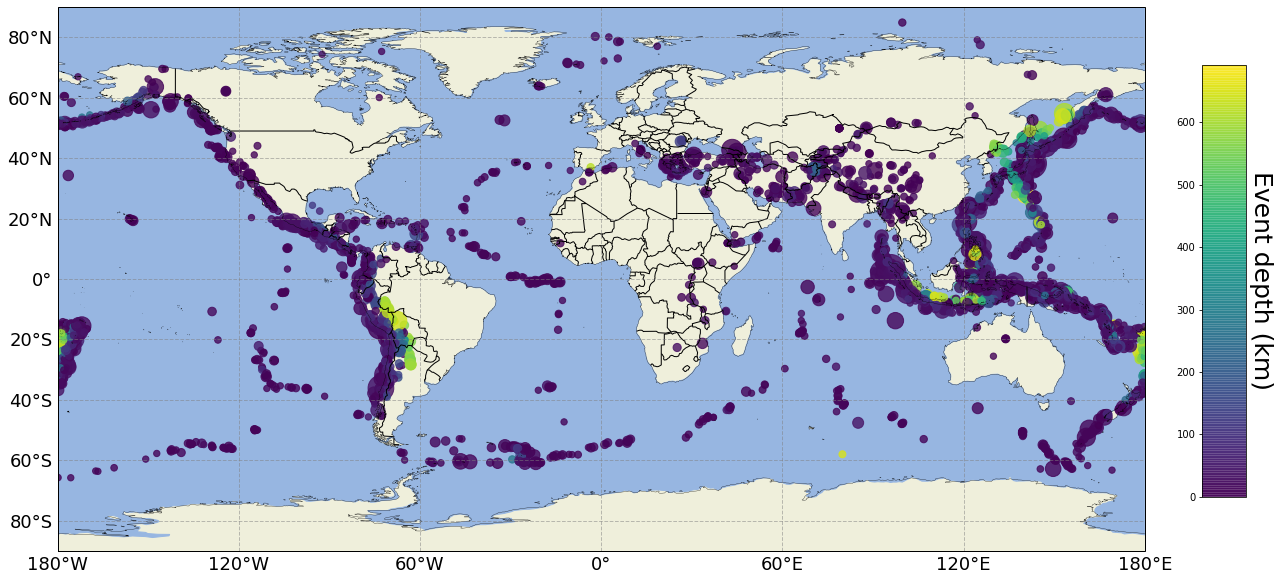

In [12]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# make the map global rather than have it zoom in to
# the extents of any plotted data
ax.set_global()

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.coastlines(resolution='50m',linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle='-')

geodetic_transform = proj._as_mpl_transform(ax)

gl = ax.gridlines(crs=proj, draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right= False 


eqs = ax.scatter(eventdetails['LON'],eventdetails['LAT'],s=scale_events(eventdetails['MAG']),c=eventdetails['DEP'],\
        transform=proj,alpha=0.8)

bar_ax = fig.add_axes([0.93, 0.2, 0.03, 0.6])

cbar = plt.colorbar(eqs,cax=bar_ax)
bar_ax.yaxis.set_ticks_position('left')
bar_ax.yaxis.set_label_position('right')
cbar.set_label('Event depth (km)', rotation=270,fontsize=25,labelpad=27)

get tectonic plate boundaries from https://github.com/fraxen/tectonicplates

In [8]:
plates = gpd.read_file("/Users/rmartinshort/Documents/Berkeley/Python_Maps/tectonicplates-master/GeoJSON/PB2002_plates.json")
boundaries = gpd.read_file("/Users/rmartinshort/Documents/Berkeley/Python_Maps/tectonicplates-master/GeoJSON/PB2002_boundaries.json")
orogens = gpd.read_file("/Users/rmartinshort/Documents/Berkeley/Python_Maps/tectonicplates-master/GeoJSON/PB2002_orogens.json")

World tectonic plates

In [9]:
plates.head()

,LAYER,Code,PlateName,geometry
0,plate,AF,Africa,"POLYGON ((-0.4379 -54.8518, -0.914655 -54.4535..."
1,plate,AN,Antarctica,"POLYGON ((180 -65.749397, 180 -90, -180 -90, -..."
2,plate,SO,Somalia,"POLYGON ((32.1258 -46.9998, 32.1252 -46.9975, ..."
3,plate,IN,India,"POLYGON ((56.2652 14.6232, 57.0015 14.6601, 57..."
4,plate,AU,Australia,"(POLYGON ((-180 -32.30415, -180 -15.620711, -1..."


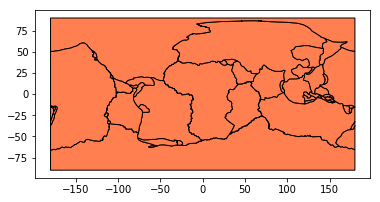

In [10]:
plates.plot(facecolor='coral',edgecolor='k');

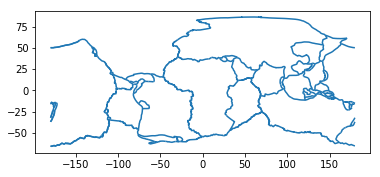

In [11]:
boundaries.plot();

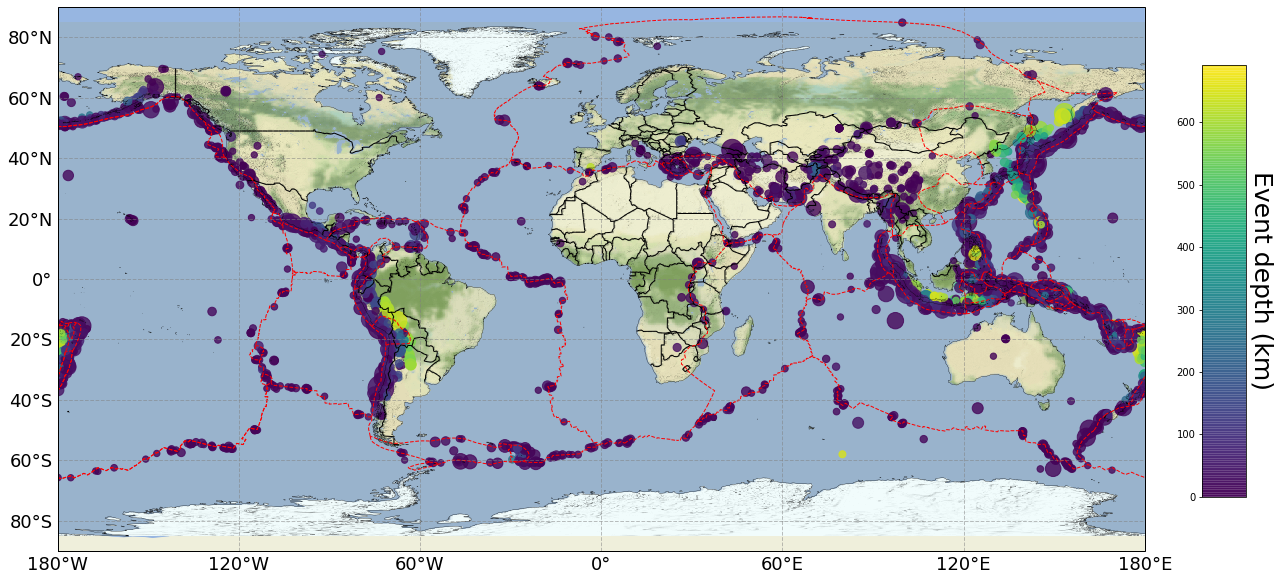

In [14]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

#add a terrain image tile
#Note that this is for image purposes only and so is not really the same as using 
#a netCDF file in GMT

stamen_terrain = cimgt.Stamen('terrain-background')

# make the map global rather than have it zoom in to
# the extents of any plotted data
ax.set_global()

# Add the Stamen data at zoom level 1.
# Be careful with the zoom levels! Setting a high zoom will take 
# a long time to download

ax.add_image(stamen_terrain,3,alpha=1)

#Add various features at low resolution (OK for global)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.coastlines(resolution='50m',linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle='-')

#Add the plate boundaries
ax.add_geometries(boundaries.geometry, crs=ccrs.PlateCarree(), facecolor='None', \
                  edgecolor='red', linestyle='--')

#Set up the grid lines
gl = ax.gridlines(crs=proj, draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right= False 

#plot the earthquakes
eqs = ax.scatter(eventdetails['LON'],eventdetails['LAT'],s=scale_events(eventdetails['MAG']),c=eventdetails['DEP'],\
        transform=proj,alpha=0.8)

bar_ax = fig.add_axes([0.93, 0.2, 0.03, 0.6])

cbar = plt.colorbar(eqs,cax=bar_ax)
bar_ax.yaxis.set_ticks_position('left')
bar_ax.yaxis.set_label_position('right')
cbar.set_label('Event depth (km)', rotation=270,fontsize=25,labelpad=27)

In [69]:
orogens.head()

,LAYER,Name,Source,geometry
0,orogen,Puna-Sierras Pampeanas,"by Peter Bird, September 2001","POLYGON ((-64.8036 -21.0378, -63.6636 -21.0517..."
1,orogen,New Hebrides-Fiji,"by Peter Bird, December 2001","(POLYGON ((-179.948 -17.4581, -180 -17.562569,..."
2,orogen,Peru,"Peter Bird, June 2002","POLYGON ((-78.6109 -2.22858, -77.8583 -2.28941..."
3,orogen,Ninety East-Sumatra,"by Peter Bird, September 2001","POLYGON ((91.6816 10.5126, 91.6576 10.0577, 91..."
4,orogen,Rivera-Cocos,"by Peter Bird, September 2001; after DeMets an...","POLYGON ((-105.049 18.6661, -104.678 18.3789, ..."


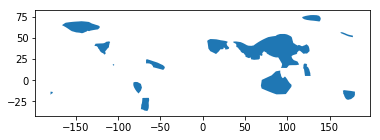

In [70]:
orogens.plot()